In [2]:
import numpy as np
import copy
from IPython.display import HTML
import matplotlib.pyplot as plt
import dill

import SimPEG as simpeg
from SimPEG.EM import NSEM

import sys
from pymatsolver import PardisoSolver
import telluricpy

# Set some matplotlib settings
%matplotlib notebook


In [3]:
# Define the area of interest
bw, be = -250., 250
bs, bn = -250., 250.
bb, bt = -500.,0.

In [126]:
## Comment:
# Decreased the cell sizes to 


#Cell size
csx, csy, csz = 10., 10.,5
# Number of core cells in each directiPon s
ncx, ncy, ncz = 30,3,7.
# Number of padding cells to add in each direction
npad = 13
nzpad = 14
growrate = 1.5
# Vectors of cell lengthts in each direction
hx = [(csx,npad, -growrate),(csx,ncx),(csx,npad,growrate)]
hy = [(csy,npad, -growrate),(csy,ncy),(csy,npad, growrate)]
hz = [(csz,nzpad,-growrate),(csz,ncz),(csz,nzpad, growrate)]
#hz = [(csz,npad, -1.5),(csz,ncz),(csz,npad,1.5)]

# nrCcore = [6, 5, 4, 2, 2, 2, 2]
airPad = simpeg.Utils.meshTensor([(csz,nzpad,growrate)])
# vCore = np.concatenate([ np.ones(i)*s for i, s in zip(nrCcore,(simpeg.Utils.meshTensor([(csz,1),(csz,5,1.3)])))])[::-1]
# botPad = simpeg.Utils.meshTensor([(vCore[0],2,-1.5)])
# hz = np.concatenate((botPad,vCore,airPad))

# Create mesh
mesh = simpeg.Mesh.TensorMesh([hx, hy, hz],x0="CCN")

In [127]:
print np.sum(simpeg.Utils.meshTensor([(csx,npad,growrate)]))
print np.sum(airPad)
print mesh.x0

5808.58520508
4363.93890381
[-5958.58520508 -5823.58520508 -8762.87780762]


In [128]:
# Map mesh coordinates from local to UTM coordiantes
mesh.x0[2] = mesh.x0[2]+np.sum(airPad) + 10
#mesh.x0[2] = mesh.x0[2]- csz/2.#-np.max(mesh.vectorCCz[npad:-npad]) 

# mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True)
# mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True, normal="Y")
# mesh.plotGrid()
# plt.gca().set_aspect('equal')
# plt.show()

print mesh.x0
print mesh.nC
print mesh.nF

[-5958.58520508 -5823.58520508 -4388.93890381]
56840
175119


In [80]:
mesh.vectorNx

array([-2714.92675781, -1849.95117188, -1273.30078125,  -888.8671875 ,
        -632.578125  ,  -461.71875   ,  -347.8125    ,  -271.875     ,
        -221.25      ,  -187.5       ,  -165.        ,  -150.        ,
        -140.        ,  -130.        ,  -120.        ,  -110.        ,
        -100.        ,   -90.        ,   -80.        ,   -70.        ,
         -60.        ,   -50.        ,   -40.        ,   -30.        ,
         -20.        ,   -10.        ,     0.        ,    10.        ,
          20.        ,    30.        ,    40.        ,    50.        ,
          60.        ,    70.        ,    80.        ,    90.        ,
         100.        ,   110.        ,   120.        ,   130.        ,
         140.        ,   150.        ,   165.        ,   187.5       ,
         221.25      ,   271.875     ,   347.8125    ,   461.71875   ,
         632.578125  ,   888.8671875 ,  1273.30078125,  1849.95117188,
        2714.92675781])

In [81]:
sig_air = 1e-8
sig_east = 1e-1
sig_west = 1e-2
sigma = sig_east*np.ones(mesh.nC)

#West
west = mesh.gridCC[:,0]<0
sigma[west] = sig_west

#air cells
air = mesh.gridCC[:,2]>0.
sigma[air]=sig_air

# Get a 1D background model
bgsigma = mesh.r(sigma,'CC','CC','M')[0,0,:]

<IPython.core.display.Javascript object>


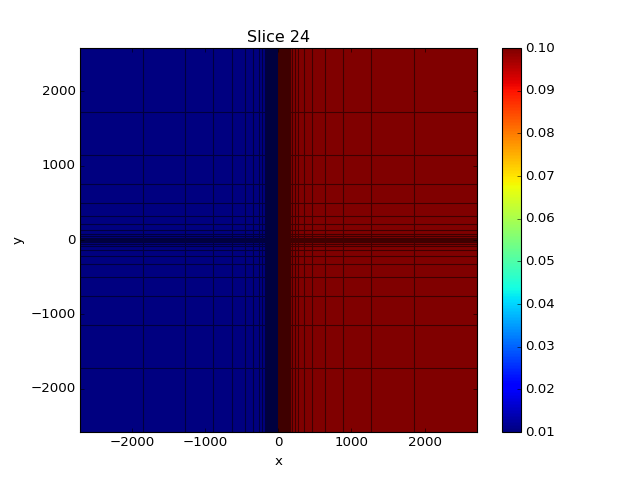

In [82]:
a = mesh.plotSlice(sigma, grid=True, normal="Z")
#plt.gca().set_xlim([-250.,250])
#plt.gca().set_ylim([-500.,10.])
plt.colorbar(a[0])

<IPython.core.display.Javascript object>


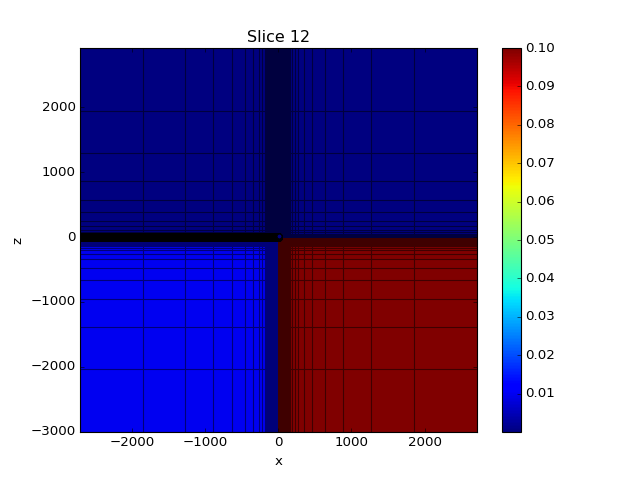

In [83]:
a = mesh.plotSlice(sigma, grid=True, normal="Y")
#plt.gca().set_xlim([-250.,250])
#plt.gca().set_ylim([-500.,10.])
plt.colorbar(a[0])

In [84]:
freqs = np.logspace(5,-2,22)
print freqs

[  1.00000000e+05   4.64158883e+04   2.15443469e+04   1.00000000e+04
   4.64158883e+03   2.15443469e+03   1.00000000e+03   4.64158883e+02
   2.15443469e+02   1.00000000e+02   4.64158883e+01   2.15443469e+01
   1.00000000e+01   4.64158883e+00   2.15443469e+00   1.00000000e+00
   4.64158883e-01   2.15443469e-01   1.00000000e-01   4.64158883e-02
   2.15443469e-02   1.00000000e-02]


In [85]:
print 500./np.sqrt(freqs*sig_east)

[  5.00000000e+00   7.33899634e+00   1.07721735e+01   1.58113883e+01
   2.32079442e+01   3.40646035e+01   5.00000000e+01   7.33899634e+01
   1.07721735e+02   1.58113883e+02   2.32079442e+02   3.40646035e+02
   5.00000000e+02   7.33899634e+02   1.07721735e+03   1.58113883e+03
   2.32079442e+03   3.40646035e+03   5.00000000e+03   7.33899634e+03
   1.07721735e+04   1.58113883e+04]


In [89]:
# Calculate the skindepth for both halfspaces
np.concatenate((freqs.reshape(1,-1),NSEM.Utils.skindepth(1./np.array([[sig_west],[sig_east]]), freqs))).T

array([[  1.00000000e+05,   1.59154943e+01,   5.03292121e+00],
       [  4.64158883e+04,   2.33607509e+01,   7.38731807e+00],
       [  2.15443469e+04,   3.42888930e+01,   1.08431000e+01],
       [  1.00000000e+04,   5.03292121e+01,   1.59154943e+01],
       [  4.64158883e+03,   7.38731807e+01,   2.33607509e+01],
       [  2.15443469e+03,   1.08431000e+02,   3.42888930e+01],
       [  1.00000000e+03,   1.59154943e+02,   5.03292121e+01],
       [  4.64158883e+02,   2.33607509e+02,   7.38731807e+01],
       [  2.15443469e+02,   3.42888930e+02,   1.08431000e+02],
       [  1.00000000e+02,   5.03292121e+02,   1.59154943e+02],
       [  4.64158883e+01,   7.38731807e+02,   2.33607509e+02],
       [  2.15443469e+01,   1.08431000e+03,   3.42888930e+02],
       [  1.00000000e+01,   1.59154943e+03,   5.03292121e+02],
       [  4.64158883e+00,   2.33607509e+03,   7.38731807e+02],
       [  2.15443469e+00,   3.42888930e+03,   1.08431000e+03],
       [  1.00000000e+00,   5.03292121e+03,   1.5915494

In [46]:
NSEM.Utils.skindepth

In [96]:
# Make the rxLocations file
x,y,z = np.meshgrid(np.arange(-145,146,10),np.arange(-10,11,10),[0.])
locs = np.hstack((x.reshape(-1,1),y.reshape(-1,1),z.reshape(-1,1)))


In [97]:
mesh.vectorCCy

array([-2147.43896484, -1426.62597656,  -946.08398438,  -625.72265625,
        -412.1484375 ,  -269.765625  ,  -174.84375   ,  -111.5625    ,
         -69.375     ,   -41.25      ,   -22.5       ,   -10.        ,
           0.        ,    10.        ,    22.5       ,    41.25      ,
          69.375     ,   111.5625    ,   174.84375   ,   269.765625  ,
         412.1484375 ,   625.72265625,   946.08398438,  1426.62597656,
        2147.43896484])

<IPython.core.display.Javascript object>


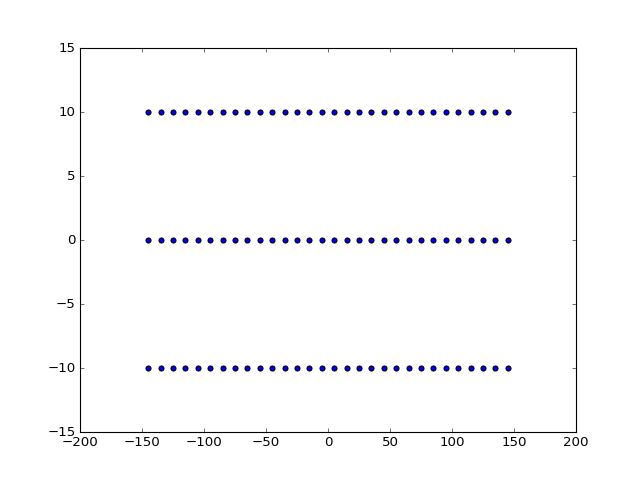

In [98]:
%matplotlib notebook
plt.scatter(locs[:,0],locs[:,1])

In [99]:
rxList = []        
for rx_orientation in ['xx', 'xy', 'yx', 'yy']:
    rxList.append(NSEM.Rx.Point_impedance3D(locs,rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_impedance3D(locs,rx_orientation, 'imag'))            
for rx_orientation in ['zx','zy']:
    rxList.append(NSEM.Rx.Point_tipper3D(locs,rx_orientation, 'real'))
    rxList.append(NSEM.Rx.Point_tipper3D(locs,rx_orientation, 'imag'))
# Source list
srcList =[]
for freq in freqs:
    srcList.append(NSEM.Src.Planewave_xy_1Dprimary(rxList,freq))
# Survey MT
survey = NSEM.Survey(srcList)
# Background 1D model
sigma1d = mesh.r(sigma,'CC','CC','M')[0,0,:]
## Setup the problem object
problem = NSEM.Problem3D_ePrimSec(mesh, sigmaMap=simpeg.Maps.IdentityMap(), sigmaPrimary = sigma1d)
problem.verbose = True

problem.Solver = PardisoSolver
problem.pair(survey)

import time
## Calculate the fields
stTime = time.time()
print 'Starting calculating field solution at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
FmtSer = problem.fields(sigma)
print 'Ended calculation field at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)

## Project data
stTime = time.time()
print 'Starting projecting fields to data at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
mtData = NSEM.Data(survey,survey.eval(FmtSer))
print 'Ended projection of fields at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)

Starting calculating field solution at 2016-12-28 11:52:28
Starting work for 1.000e-02
Ran for 52.371517 seconds
Starting work for 2.154e-02
Ran for 50.881693 seconds
Starting work for 4.642e-02
Ran for 49.078126 seconds
Starting work for 1.000e-01
Ran for 49.020716 seconds
Starting work for 2.154e-01
Ran for 44.101292 seconds
Starting work for 4.642e-01
Ran for 41.750551 seconds
Starting work for 1.000e+00
Ran for 41.828858 seconds
Starting work for 2.154e+00
Ran for 45.220697 seconds
Starting work for 4.642e+00
Ran for 45.523894 seconds
Starting work for 1.000e+01
Ran for 44.397557 seconds
Starting work for 2.154e+01
Ran for 45.961229 seconds
Starting work for 4.642e+01
Ran for 53.739368 seconds
Starting work for 1.000e+02
Ran for 44.631328 seconds
Starting work for 2.154e+02
Ran for 46.445272 seconds
Starting work for 4.642e+02
Ran for 46.669392 seconds
Starting work for 1.000e+03
Ran for 49.033048 seconds
Starting work for 2.154e+03
Ran for 46.663259 seconds
Starting work for 4.642

In [100]:
# Pickle the data
mtData.survey.unpair()

dill.dump(mtData,open('vertical_contact_mtData_1e2_1e1.pklb','wb'))

In [101]:
mtData = dill.load(open('vertical_contact_mtData_1e2_1e1.pklb','rb'))

<IPython.core.display.Javascript object>


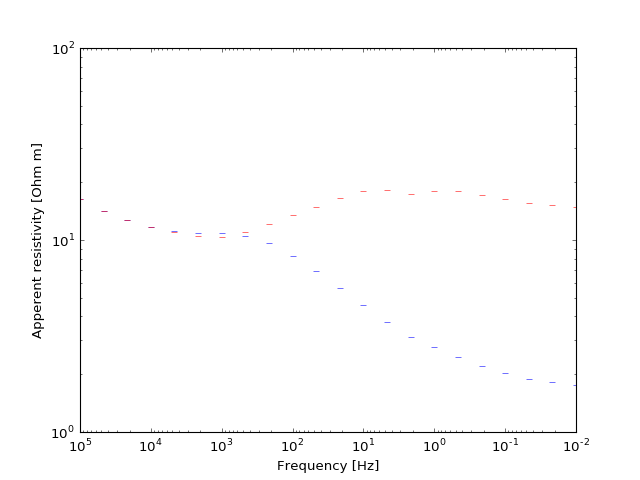

In [103]:
mtData.plot_app_res(np.array([95.,0.]))

<IPython.core.display.Javascript object>


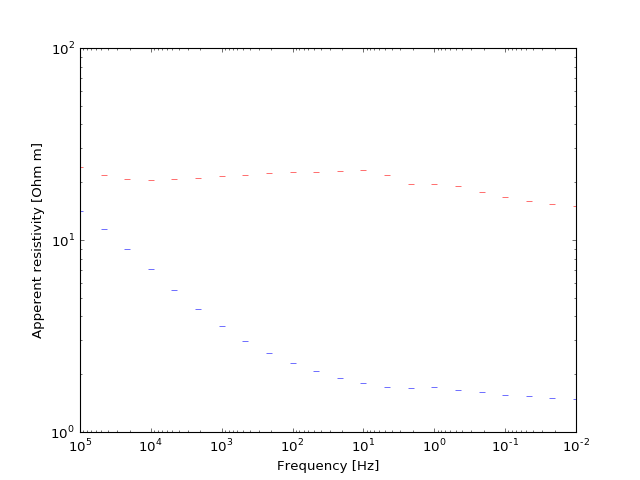

In [105]:
mtData.plot_app_res(np.array([5.,0.]))

<IPython.core.display.Javascript object>


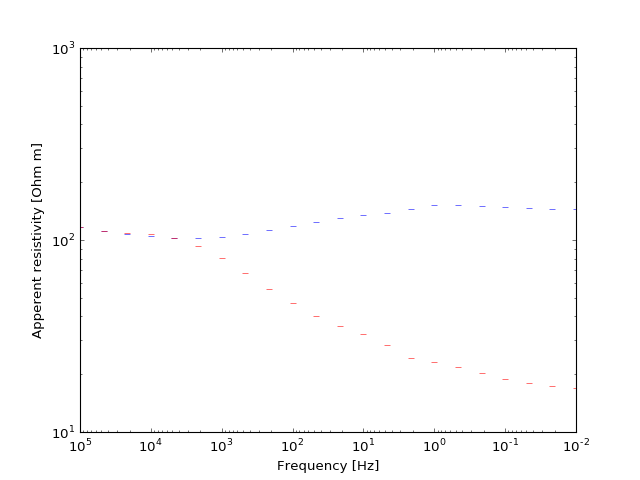

In [106]:
mtData.plot_app_res(np.array([-95.,0.]))

<IPython.core.display.Javascript object>


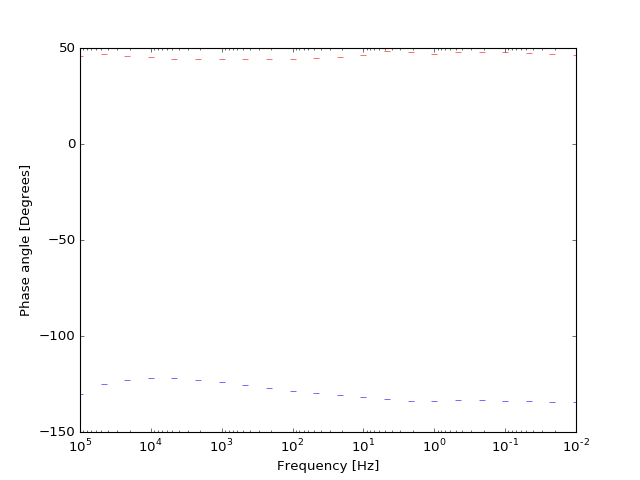

In [107]:
mtData.plot_app_phs(np.array([5.,0.]))